In [1]:
# Importing stuff...
try:
    from undi import MuonNuclearInteraction
except (ImportError, ModuleNotFoundError):
    import sys
    sys.path.append('../undi')
    from undi import MuonNuclearInteraction
import matplotlib.pyplot as plt
import numpy as np

# LaCuO4

This notebook tries to reproduce the results first appeared in

1. [10.1016/j.phpro.2012.04.056](https://doi.org/10.1016/j.phpro.2012.04.056)
2. [10.1103/PhysRevB.85.104527](https://doi.org/10.1103/PhysRevB.85.104527) ( or [arXiv:1201.5406](https://arxiv.org/pdf/1201.5406.pdf) )

that describe muon polarization in single crystal La$_{2-x}$Sr$_x$CuO$_4$.
 
Some additional information can be found here:

 * https://journals.aps.org/prb/abstract/10.1103/PhysRevB.49.9879
 * https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.72.760
 * https://doi.org/10.1103/PhysRevB.64.134525

An overview of the results reported in 1. and 2. is in the following patchwork:
![LSCO](images/LSCO.png)

The positions and the number of neighbours reported in 1. and 2. are:

| Label | Ref. |  Muon               | Site Nuclei Included in Calculation    |
| ----- | ---- |:-------------------:| --------------------------------------:|
| M     | 1    | (0.5, 0.0, 0.096)   | 2Cu, La(2), La(2)                      |
| T1    | 1    | (0.2, 0.0, 0.15)    | 2Cu, La(1), La(2), La(2)               |
| T2    | 1    | (0.225, 0.0, 0.225) | 2Cu, La(1), La(2), La(2)               |
| U1    | 1    | (0.12, 0., 0.11)    | 2Cu, La(1), La(2), La(2), La(2)        |
| H     | 1    | (0.253, 0.0, 0.152) | 2Cu, La(1), La(2), La(2), La(2)        |
| Ba    | 1    | (0.1, 0.0, 0.1)     | Cu, La(1), La(2), La(2)                |
| Bb    | 1    | (0.1, 0.0, 0.1)     | 4Cu, La(1), La(2), La(2)               |
| A     | 1    | (0.0, 0.0, 0.15)    | 5Cu, La(1), La(2), La(2), La(2), La(2) |
| A     | 2    | (0.0, 0.0, 0.212)   | 5Cu, La(1), La(2), La(2), La(2), La(2) |
| D     | 2    | (0.12, 0.0, 0.219)  |  Cu, La(1), La(2), La(2), La(2), La(2) |

N.B: the table above is taken from the article published in Physics Procedia.
     Site A and U1 differ from the ones reported in PRB (tble in the picture above).

N.B 2: also notice that T2 is reported to have the same position in the two papers
       but its signal (light green line) is different in the pictures above.

In the implementation below the EFG generated by the muon is neglected
(i.e. Eq. 7 in the picture above). This is because I was unable to find
the parameters used in the paper mentioned above.

In [2]:
# Input data and constants. Some of them are taken from the articles mentioned above.

angtom=1.0e-10 # m

Quadrupole_moment = {
    'Cu' : -( 0.7 * 0.22   +   0.3 * 0.204 ) * 1e-28 ,  # m^2 , average between 63Cu and 65Cu
    'La' :  0.20e-28     # m^2
}

Gamma = {
    'Cu': ( 0.7 * 71.118   +   0.3 * 76.044 ) * 1e6, # Average between 63Cu and 65Cu
    'La': 38.083                              * 1e6  # La
}

Omega = {
    'Cu': 2*np.pi*34.0e6,          #  213.6e6 or 194.8e6 # Hz
    'La': 2*np.pi*6.4e6            #  40.2e6
}

eta={
    'Cu': 0.02,              # eta is set to zero even if it's value
    'La': 0.03               # is reported to be sligthly different.
}

From "Nuclear Quadrupole Resonance Spectroscopy" by Hand and Das, Solid State Physics Supplement 1, the NQR transition frequency $\omega$ for a spin $S$ with electric field gradient principal component $V_{zz}$ and quadrupole moment $Q$ is


$\begin{align}
    A &= \frac{eV_{zz}Q}{4S(2S-1)}\\
    \omega &= 3 A (2 |m| + 1)/\hbar
\end{align}$

for all available transitions $m \rightarrow m+1$ where $-S \le m \le S$.

In [3]:
def EFG_from_omegaq_PAS(omegaq, eta, m, I, Q):
    #
    # (2/3) (planck2pi × 1s^−1 )/(elementary_charge × 1 m^2) = ((2 ∕ 3) × (planck2pi × (1 × (second^−1)))) ∕ (elementary_charge × (1 × (meter^2))) to volt × (meter^−2)
    # 4.3880797E-16 volt ∕ meter^2
    # the following is equivalent to the value provided below
    #  Vzz = omegaq * (I*(2*I-1))  * 4.3880797E-16 / Q
    #
    plank2pi = 1.0545718E-34 #joule second
    elementary_charge=1.6021766E-19     # Coulomb = ampere ⋅ second
    
    A = omegaq / (3 * (2*np.abs(m)+1)/plank2pi)
    Vzz = A * (4 * I * (2 * I -1))/(Q * elementary_charge)
    
    
    Vxx = (Vzz/2.0) * (eta-1)
    Vyy = -(Vzz/2.0) * (eta+1)
    return np.diag([Vxx, Vyy,Vzz])

### Functions to calculate the EFG generated by the muon

These are just a bunch of functions that are not currently used.

In [4]:
elementary_charge=1.6021766E-19 # Coulomb = ampere ⋅ second

def Vzz_for_unit_charge_at_distance(r):
    epsilon0 = 8.8541878E-12 # ampere^2 ⋅ kilogram^−1 ⋅ meter^−3 ⋅ second^4
    elementary_charge=1.6021766E-19 # Coulomb = ampere ⋅ second
    Vzz = (2./(4 * np.pi * epsilon0)) * (elementary_charge / (r**3))
    return Vzz

def gen_radial_EFG(p_mu, p_N, Vzz=None):
    x=p_N-p_mu
    n = np.linalg.norm(x)

    if Vzz is None:
        Vzz = Vzz_for_unit_charge_at_distance(n)

    x /= n; r = 1. # keeping formula below for clarity
    return -Vzz * ( (3.*np.outer(x,x)-np.eye(3)*(r**2))/r**5 ) * 0.5

def get_omegaQ_mu(I,Q,d):
    epsilon0 = 8.8541878E-12 # ampere^2 ⋅ kilogram^−1 ⋅ meter^−3 ⋅ second^4
    elementary_charge=1.6021766E-19 # Coulomb = ampere ⋅ second
    h=6.6260693e-34 # Js
    hbar=h/(2*np.pi) # Js
    
    return - (1/hbar) * (1./(4 * np.pi * epsilon0)) * (3 * elementary_charge**2 * Q) / (2*I*(2*I-1)*d**3)

### Calculate Signal

The function below creates the input data for the UNDI code starting
from the structured deposited at COD with ID: 1008481.

In the final part of this cell I added a simple wrapper 
that repeats a Celio estimate.

In [5]:
def gen_neighbouring_atomic_structure(muon_position, cutoffs):
    from ase.io import read
    from ase.atom import Atom
    from ase.neighborlist import neighbor_list
    
    
    atoms = read('./structures/1008481.cif')
    atoms.extend(Atom('H', [0,0,0]))
        
    # update muon position
    pos = atoms.get_scaled_positions()
    pos[-1] = muon_position
    atoms.set_scaled_positions(pos)
    
    ai,aj,D = neighbor_list('ijD',atoms, 10.) # very large cutoff to get all possible interactions.
                                              # Actual selection is done below
    
    data = []
    muon_pos = np.array([0,0,0])
    for i in range(len(D)):
        if not (ai[i] == len(atoms)-1):
            continue
        
        symb = atoms[aj[i]].symbol
            
        if np.linalg.norm(D[i]) > cutoffs.get(symb, 0):
            continue
        
        if symb in cutoffs.keys():
            
            pos = D[i] * angtom
            print('Adding atom ', symb , ' with position', pos, ' and distance ', np.linalg.norm(pos))
            
            
            # Nuclear part of EFG
            spin = 7./2. if symb == 'La' else 3./2.
            EFG_tensor = EFG_from_omegaq_PAS(Omega[symb], eta[symb], 1./2., spin, Quadrupole_moment[symb])

            # Muon part of EFG (the muon is always at 0)
            #EFG_tensor += gen_radial_EFG(muon_pos, pos)
            
            
            data.append({'Position': pos,
                         'Label': symb,
                         'Gamma': Gamma[symb],
                         'ElectricQuadrupoleMoment': Quadrupole_moment[symb],
                         'EFGTensor': EFG_tensor,
                         'OmegaQmu': get_omegaQ_mu(spin, Quadrupole_moment[symb], np.linalg.norm(pos))
                         })
    data.insert(0, 
                    {'Position': muon_pos,
                     'Label': 'mu'},
                )
    return data


def gen_signal(atoms, pol_direction, k=2, nrep=1):
    ttime=20
    steps = 100
    tlist = np.linspace(0, ttime*1e-6, steps)
    
        
    NS = MuonNuclearInteraction(atoms)
    NS.translate_rotate_sample_vec(pol_direction)
    
    print("Computing signal...", end='', flush=True)
    signal = np.zeros_like(tlist)
    # Do we need more random realizations? Celio used 4 for a 8192 dim. H space.
    for i in range(nrep):
        signal += NS.celio(tlist,  k=k)
    signal /= nrep
    print('done!')
    del NS
    
    return signal

### Sites

Here we go through the various sites analyzed in the papers.

#### Site D

![D](images/Site_D.png)

Muon site $D$ is in (0.120, 0, 0.219).
As reported in the original papers, we get 1Cu, 1La(1) and 4La(2).
This can also be seen by the 'z' coordinate of each La atom. Cutoff for both species is set to 3.2 Ang.

/usr/lib/python3.8/site-packages/ase/io/cif.py:377: UserWarning: crystal system 'tetragonal' is not interpreted for space group Spacegroup(139, setting=1). This may result in wrong setting!
  warnings.warn(


Adding atom  La  with position [ 1.436134e-10  1.889650e-10 -1.054680e-10]  and distance  2.5972308120103614e-10
Adding atom  Cu  with position [-4.53516e-11  0.00000e+00 -2.89080e-10]  and distance  2.926158130083882e-10
Adding atom  La  with position [-4.53516e-11  0.00000e+00  1.87308e-10]  and distance  1.92720145513021e-10
Adding atom  La  with position [-2.343166e-10  1.889650e-10 -1.054680e-10]  and distance  3.189600904259967e-10
Adding atom  La  with position [ 1.436134e-10 -1.889650e-10 -1.054680e-10]  and distance  2.5972308120103614e-10
Adding atom  La  with position [-2.343166e-10 -1.889650e-10 -1.054680e-10]  and distance  3.189600904259967e-10
Computing signal...

done!
Computing signal...done!


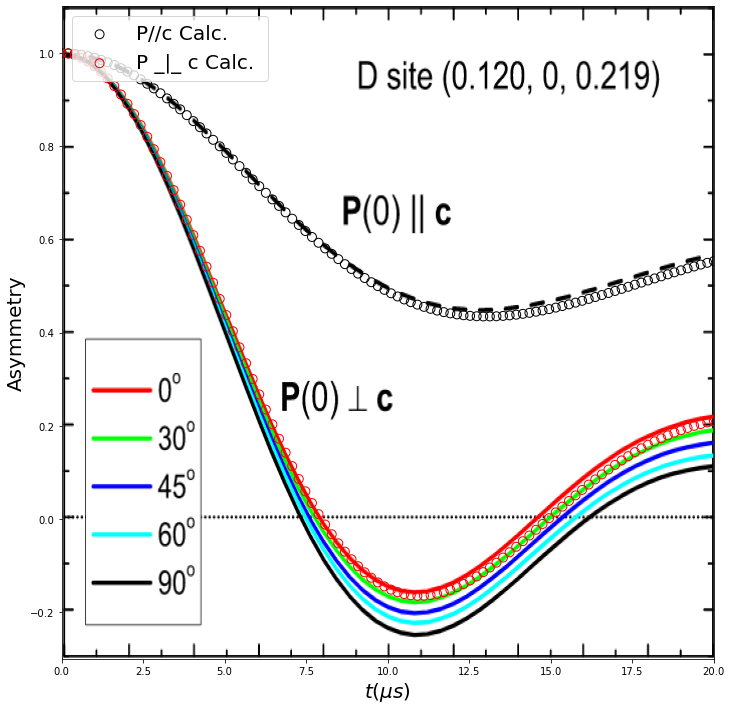

In [6]:
ttime=20
steps = 100
tlist = np.linspace(0, ttime*1e-6, steps)

atoms = gen_neighbouring_atomic_structure([0.12,  0.,  0.219], cutoffs={'Cu': 3.2, 'La': 3.2})

signal_D_Pa = gen_signal(atoms, np.array([1.,0.,0.]))
signal_D_Pc = gen_signal(atoms, np.array([0.,0.,1.]))

fig, axes = plt.subplots(1,1, figsize=(12,12))
axes.scatter(tlist*1e6,signal_D_Pc, color='k', s=80, facecolors='none', marker='o', label='P//c Calc. ', zorder=1)
axes.scatter(tlist*1e6,signal_D_Pa, color='r', s=80, facecolors='none', marker='o', label='P _|_ c Calc. ', zorder=2)

imdata = plt.imread('images/Fig6.png')
axes.imshow(imdata, zorder=0, extent=[0., 20.0, -0.3, 1.1], aspect=20/(1.1+0.3), resample=True)

axes.set_ylim([-0.3,1.1])
axes.set_xlim([0,20])
axes.set_xlabel(r'$t (\mu s)$', fontsize=20)
axes.set_ylabel(r'Asymmetry', fontsize=20);

plt.legend(loc=2, fontsize=20)
plt.savefig("D.png")
plt.show()

#### Site M

![M](images/Site_M.png)

Site M is in (0.5, 0.0, 0.096). Also in this case the number of neighbours
matches the values reported in 1. and 2.

Adding atom  La  with position [0.00000e+00 1.88965e-10 5.68920e-11]  and distance  1.9734353520954265e-10
Adding atom  Cu  with position [-1.88965e-10  0.00000e+00 -1.26720e-10]  and distance  2.2752083338674725e-10
Adding atom  Cu  with position [ 1.88965e-10  0.00000e+00 -1.26720e-10]  and distance  2.2752083338674725e-10
Adding atom  La  with position [ 0.00000e+00 -1.88965e-10  5.68920e-11]  and distance  1.9734353520954265e-10
Computing signal...

Computing signal...

done!
Computing signal...

done!
Computing signal...

done!
Computing signal...done!
done!


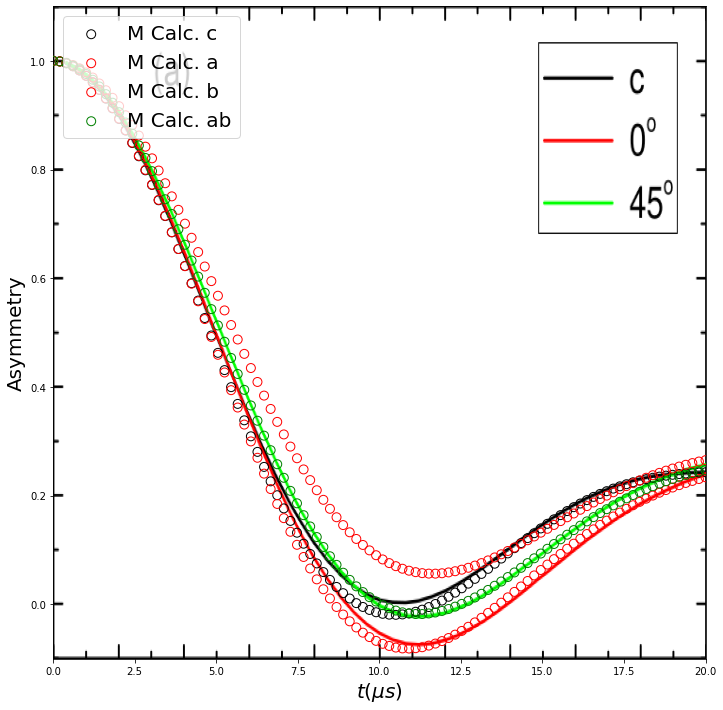

In [7]:
atoms = gen_neighbouring_atomic_structure([0.5,  0.,  0.096], cutoffs={'Cu':3.2, 'La':3.2})

print("Computing signal...", end='', flush=True)
signal_M_Pc = gen_signal(atoms, np.array([0.,0.,1.]), k=4, nrep=8)
signal_M_Pa = gen_signal(atoms, np.array([1.,0.,0.]), k=4, nrep=8)
signal_M_Pb = gen_signal(atoms, np.array([0.,1.,0.]), k=4, nrep=8)
signal_M_Pab = gen_signal(atoms, np.array([1.,1.,0.]), k=4, nrep=8)
print('done!')


imdata = plt.imread('images/Site_M_Thesis.png')

fig, axes = plt.subplots(1,1, figsize=(12,12))

axes.scatter(tlist*1e6,signal_M_Pc, color='k', s=80, facecolors='none', marker='o', label='M Calc. c', zorder=1)
axes.scatter(tlist*1e6,signal_M_Pa, color='r', s=80, facecolors='none', marker='o', label='M Calc. a', zorder=2)
axes.scatter(tlist*1e6,signal_M_Pb, color='r', s=80, facecolors='none', marker='o', label='M Calc. b', zorder=3)
axes.scatter(tlist*1e6,signal_M_Pab,color='g', s=80, facecolors='none', marker='o', label='M Calc. ab', zorder=4)
axes.imshow(imdata, zorder=0, extent=[0., 20.0, -0.1, 1.1], aspect=20/(1.1+0.1), resample=True)


axes.set_ylim([-0.1,1.1])
axes.set_xlim([0,20])
axes.set_xlabel(r'$t (\mu s)$', fontsize=20)
axes.set_ylabel(r'Asymmetry', fontsize=20);

plt.legend(loc=2, fontsize=20)
plt.savefig("M.png")
plt.show()

#### Site T1 and T2

The number of neighbours for these two sites match well with the ones reported in 1. and 2.

![T1T2](images/Site_T1andT2.png)

Adding atom  La  with position [ 1.13379e-10  1.88965e-10 -1.43880e-11]  and distance  2.2083836489613844e-10
Adding atom  Cu  with position [-7.5586e-11  0.0000e+00 -1.9800e-10]  and distance  2.1193688540695316e-10
Adding atom  La  with position [-7.55860e-11  0.00000e+00  2.78388e-10]  and distance  2.8846684721125235e-10
Adding atom  Cu  with position [ 3.02344e-10  0.00000e+00 -1.98000e-10]  and distance  3.614082101115026e-10
Adding atom  La  with position [ 1.13379e-10 -1.88965e-10 -1.43880e-11]  and distance  2.2083836489613844e-10
Computing signal...

Computing signal...

done!
Computing signal...

done!
Computing signal...

done!
Computing signal...done!
done!
Adding atom  La  with position [ 1.0393075e-10  1.8896500e-10 -1.1338800e-10]  and distance  2.4365182241174085e-10
Adding atom  Cu  with position [-8.503425e-11  0.000000e+00 -2.970000e-10]  and distance  3.0893336445431483e-10
Adding atom  La  with position [-8.503425e-11  0.000000e+00  1.793880e-10]  and distance  1.9852173235457748e-10
Adding atom  Cu  with position [ 2.9289575e-10  0.0000000e+00 -2.9700000e-10]  and distance  4.1712938084971013e-10
Adding atom  La  with position [ 1.0393075e-10 -1.8896500e-10 -1.1338800e-10]  and distance  2.4365182241174085e-10
Computing signal...

Computing signal...

done!


Computing signal...

done!
Computing signal...

done!
Computing signal...done!
done!


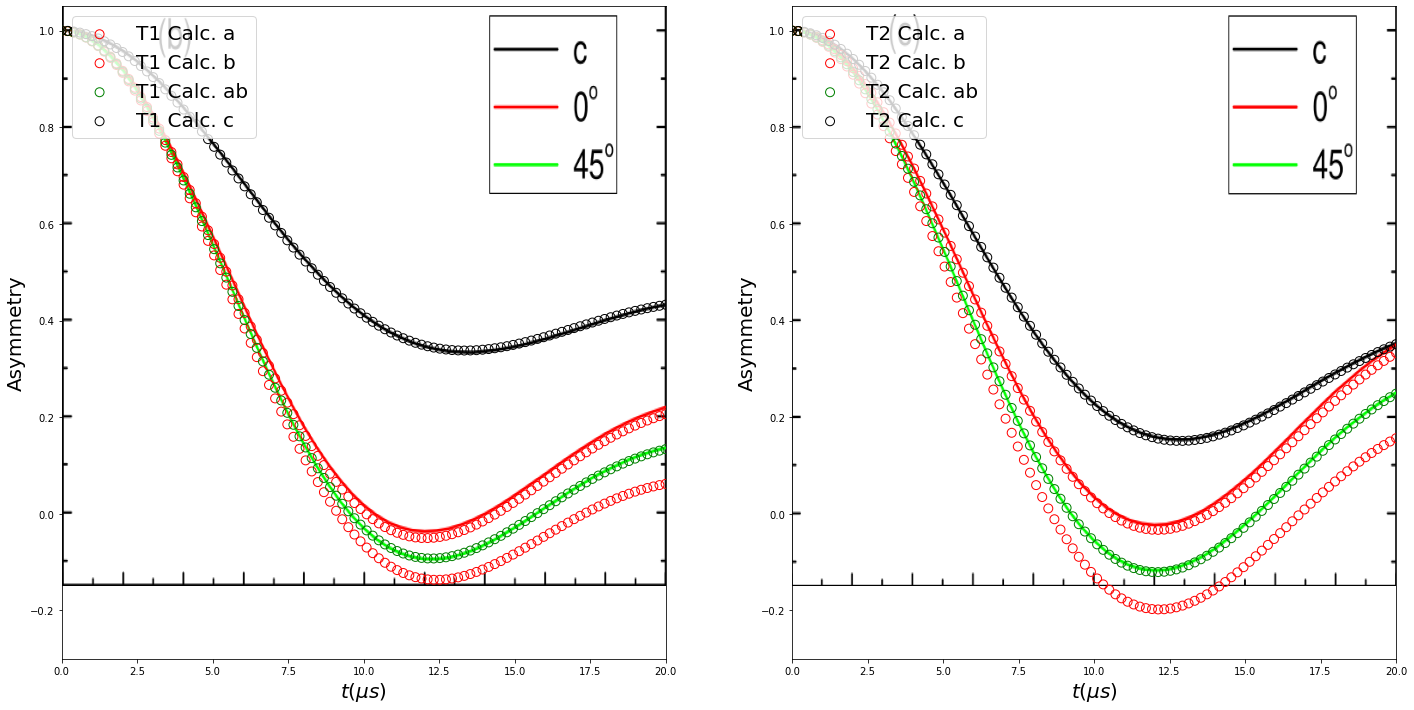

In [8]:
atoms = gen_neighbouring_atomic_structure([0.2,  0.,  0.15], cutoffs={'Cu':4., 'La':3.}) 

print("Computing signal...", end='', flush=True)
signal_T1_Pa = gen_signal(atoms, np.array([1.,0.,0.]), nrep=2)
signal_T1_Pb = gen_signal(atoms, np.array([0.,1.,0.]), nrep=2)
signal_T1_Pab = gen_signal(atoms, np.array([1.,1.,0.]), nrep=2)
signal_T1_Pc = gen_signal(atoms, np.array([0.,0.,1.]), nrep=2)
print('done!')

atoms = gen_neighbouring_atomic_structure([0.225,  0.,  0.225], cutoffs={'Cu':4.2, 'La':3.})

print("Computing signal...", end='', flush=True)
signal_T2_Pa = gen_signal(atoms, np.array([1.,0.,0.]), nrep=2)
signal_T2_Pb = gen_signal(atoms, np.array([0.,1.,0.]), nrep=2)
signal_T2_Pab = gen_signal(atoms, np.array([1.,1.,0.]), nrep=2)
signal_T2_Pc = gen_signal(atoms, np.array([0.,0.,1.]), nrep=2)

print('done!')



fig, [ax1, ax2] = plt.subplots(1,2, figsize=(24,12))

ax1.scatter(tlist*1e6,signal_T1_Pa, color='r', s=80, facecolors='none', marker='o',label='T1 Calc. a', zorder=1)
ax1.scatter(tlist*1e6,signal_T1_Pb, color='r', s=80, facecolors='none', marker='o',label='T1 Calc. b', zorder=2)
ax1.scatter(tlist*1e6,signal_T1_Pab, color='g', s=80, facecolors='none',  marker='o',label='T1 Calc. ab', zorder=3)
ax1.scatter(tlist*1e6,signal_T1_Pc, color='k', s=80, facecolors='none', marker='o',label='T1 Calc. c', zorder=4)

imdata = plt.imread('images/Site_T1_Thesis.png')
ax1.imshow(imdata, zorder=0, extent=[0., 20.0, -0.15, 1.1], aspect=20/(1.1+0.15), resample=True)


ax2.scatter(tlist*1e6,signal_T2_Pa, color='r', s=80, facecolors='none', marker='o',label='T2 Calc. a', zorder=1)
ax2.scatter(tlist*1e6,signal_T2_Pb, color='r', s=80, facecolors='none', marker='o',label='T2 Calc. b', zorder=2)
ax2.scatter(tlist*1e6,signal_T2_Pab, color='g', s=80, facecolors='none',  marker='o',label='T2 Calc. ab', zorder=3)
ax2.scatter(tlist*1e6,signal_T2_Pc, color='k', s=80, facecolors='none', marker='o',label='T2 Calc. c', zorder=4)

imdata = plt.imread('images/Site_T2_Thesis.png')
ax2.imshow(imdata, zorder=0, extent=[0., 20.0, -0.15, 1.1], aspect=20/(1.1+0.15), resample=True)


for ax in (ax1,ax2):
    ax.set_ylim([-0.3,1.05])
    ax.set_xlim([0,20])
    ax.set_xlabel(r'$t (\mu s)$', fontsize=20)
    ax.set_ylabel(r'Asymmetry', fontsize=20);

    ax.legend(loc=2, fontsize=20)

plt.savefig("T1_and_T2.png")
plt.show()

#### Site Ba (not really)

![Ba](images/Site_Ba.png)

This site does not really match with what is reported in the papers.
According to the table above, there should be

     Cu, La(1), La(2), La(2)

If I set a 3.5 Ang. cutoff for La, I get 1Cu, 1La(1) and 4La(2). The
distances are indeed

      l(La2-Ba) =  2.4744(12) Å     (first couple)
      l(La2-Ba) =  2.9965(10) Å     (second couple)
      l(La1-Ba) =  3.465(6) Å

Adding atom  La  with position [1.51172e-10 1.88965e-10 5.16120e-11]  and distance  2.474359378768573e-10
Adding atom  Cu  with position [-3.7793e-11  0.0000e+00 -1.3200e-10]  and distance  1.3730371753525105e-10
Adding atom  La  with position [-3.77930e-11  0.00000e+00  3.44388e-10]  and distance  3.4645548832858736e-10
Adding atom  La  with position [-2.26758e-10  1.88965e-10  5.16120e-11]  and distance  2.996510642947894e-10
Adding atom  La  with position [ 1.51172e-10 -1.88965e-10  5.16120e-11]  and distance  2.474359378768573e-10
Adding atom  La  with position [-2.26758e-10 -1.88965e-10  5.16120e-11]  and distance  2.996510642947894e-10
Computing signal...

Computing signal...done!
done!


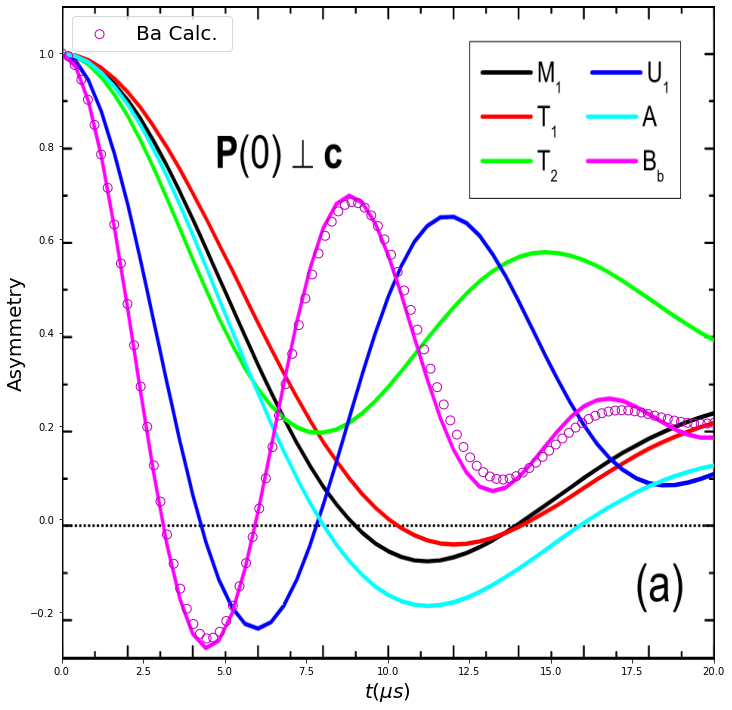

In [9]:
atoms = gen_neighbouring_atomic_structure([0.1,  0.,  0.1], cutoffs={'Cu':2., 'La':3.5})

print("Computing signal...", end='', flush=True)
signal_Ba_Pab = gen_signal(atoms, np.array([1.,0.,0.]),k=1)
print('done!')

imdata = plt.imread('images/Fig5a.png')

fig, axes = plt.subplots(1,1, figsize=(12,12))

axes.scatter(tlist*1e6,signal_Ba_Pab, color='m', s=80, facecolors='none', marker='o', label='Ba Calc. ', zorder=1)
axes.imshow(imdata, zorder=0, extent=[0., 20.0, -0.3, 1.1], aspect=20/(1.1+0.3), resample=True)

axes.set_ylim([-0.3,1.1])
axes.set_xlim([0,20])
axes.set_xlabel(r'$t (\mu s)$', fontsize=20)
axes.set_ylabel(r'Asymmetry', fontsize=20);

plt.legend(loc=2, fontsize=20)
plt.savefig("Ba.png")
plt.show()

#### Site U1 (not really)

Site U1, coords. (0.12, 0., 0.11), is reported to have

    2Cu, La(1), La(2), La(2), La(2)     [PhysProc]
    2Cu, La(1), La(2), La(2)            [PRB]

Both these options look strange because the distance between the muon and La are:

    l(La2-U1) =  2.4043(9) Å  (first couple of La2)
    l(La2-U1) =  3.0346(8) Å  (second couple of La2)
    l(La1-U1) =  3.343(6) Å   (first neighbouring La1)

So if I set 3.5 Ang. cutoff I get a different set of La. Setting it to 3.1 for the time being.

![U1](images/Site_U1.png)

Adding atom  La  with position [1.436134e-10 1.889650e-10 3.841200e-11]  and distance  2.4043307099598423e-10
Adding atom  Cu  with position [-4.53516e-11  0.00000e+00 -1.45200e-10]  and distance  1.521177426290569e-10
Adding atom  La  with position [-2.343166e-10  1.889650e-10  3.841200e-11]  and distance  3.034592592170488e-10
Adding atom  Cu  with position [ 3.325784e-10  0.000000e+00 -1.452000e-10]  and distance  3.6289314149837554e-10
Adding atom  La  with position [ 1.436134e-10 -1.889650e-10  3.841200e-11]  and distance  2.4043307099598423e-10
Adding atom  La  with position [-2.343166e-10 -1.889650e-10  3.841200e-11]  and distance  3.034592592170488e-10
Computing signal...

Computing signal...

done!
Computing signal...

done!
Computing signal...

done!
Computing signal...done!
done!


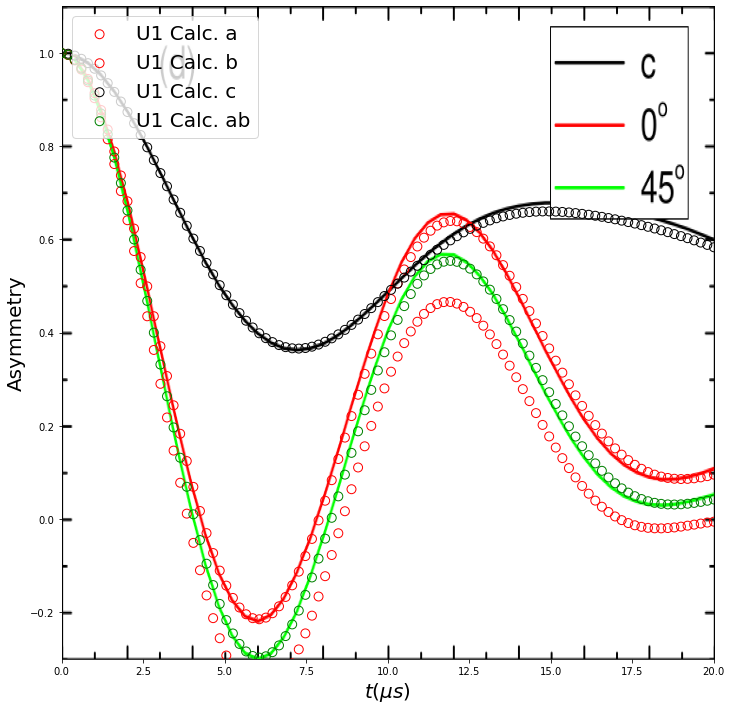

In [10]:
atoms = gen_neighbouring_atomic_structure([0.12,  0.,  0.11], cutoffs={'Cu':3.7, 'La':3.1})

print("Computing signal...", end='', flush=True)
signal_U1_Pa = gen_signal(atoms, np.array([1.,0.,0.]), nrep=2, k=4)
signal_U1_Pb = gen_signal(atoms, np.array([0.,1.,0.]), nrep=2, k=4)
signal_U1_Pc = gen_signal(atoms, np.array([0.,0.,1.]), nrep=2, k=4)
signal_U1_Pab = gen_signal(atoms, np.array([1.,1.,0.]), nrep=2, k=4)
print('done!')

imdata = plt.imread('images/Site_U1_Thesis.png')

fig, axes = plt.subplots(1,1, figsize=(12,12))

axes.scatter(tlist*1e6,signal_U1_Pa, color='r', s=80, facecolors='none',marker='o',label='U1 Calc. a', zorder=1)
axes.scatter(tlist*1e6,signal_U1_Pb, color='r', s=80, facecolors='none',marker='o',label='U1 Calc. b', zorder=2)
axes.scatter(tlist*1e6,signal_U1_Pc, color='k', s=80, facecolors='none',marker='o',label='U1 Calc. c', zorder=3)
axes.scatter(tlist*1e6,signal_U1_Pab,color='g', s=80, facecolors='none',marker='o',label='U1 Calc. ab', zorder=4)
axes.imshow(imdata, zorder=0, extent=[0., 20.0, -0.3, 1.1], aspect=20/(1.1+0.3), resample=True)


axes.set_ylim([-0.3,1.1])
axes.set_xlim([0,20])
axes.set_xlabel(r'$t (\mu s)$', fontsize=20)
axes.set_ylabel(r'Asymmetry', fontsize=20);


plt.legend(loc=2, fontsize=20)
plt.savefig("U1.png")
plt.show()